In [1]:
# Librerías
using Lux
using Random
using Zygote
using Optimisers
using Plots
using Distributions
using Statistics

In [19]:
# Hiperparametros
N_SAMPLES = 200
LAYERS = [1, 10, 10, 10, 1]
LEARNING_RATE = 0.1
N_EPOCHS = 50_000

# Generador de números pseudoaleatorios
rng = Xoshiro(2025)

Xoshiro(0x9be4c2c067bd8330, 0x32d7000c630d1ffb, 0x1f0632f9ee926dd2, 0x887b1278b053c1cc, 0x8ae643140c0b54cf)

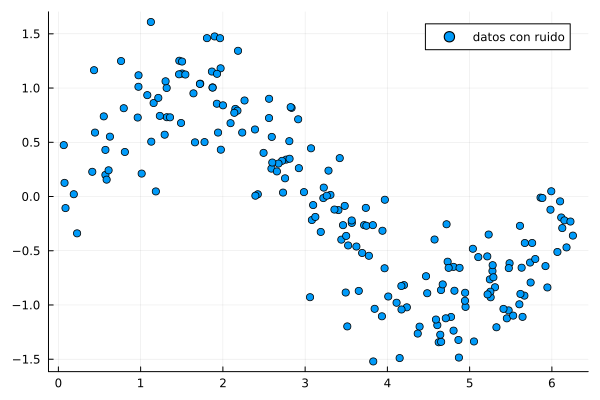

In [11]:
# Generar datos con ruido
x_samples = rand(
    rng,
    Uniform(0.0, 2 * π),
    (1, N_SAMPLES),
)
y_noise = rand(
    rng,
    Normal(0.0, 0.3),
    (1, N_SAMPLES),
)
y_samples = sin.(x_samples) .+ y_noise

scatter(x_samples[:], y_samples[:], label="datos con ruido")

In [4]:
# Definir la arquitectura del modelo
model = Chain(
    [Dense(fan_in => fan_out, Lux.sigmoid) for (fan_in, fan_out) in zip(LAYERS[1:end-2], LAYERS[2:end-1])]...,
    Dense(LAYERS[end-1] => LAYERS[end], identity),
)

Chain(
    layer_1 = Dense(1 => 10, σ),                  # 20 parameters
    layer_(2-3) = Dense(10 => 10, σ),             # 220 (110 x 2) parameters
    layer_4 = Dense(10 => 1),                     # 11 parameters
)         # Total: 251 parameters,
          #        plus 0 states.

┌ Warning: Mixed-Precision `matmul_cpu_fallback!` detected and Octavian.jl cannot be used for this set of inputs (C [Matrix{Float64}]: A [Matrix{Float32}] x B [Matrix{Float64}]). Falling back to generic implementation. This may be slow.
└ @ LuxLib.Impl /Users/julio/.julia/packages/LuxLib/uQ1j6/src/impl/matmul.jl:190


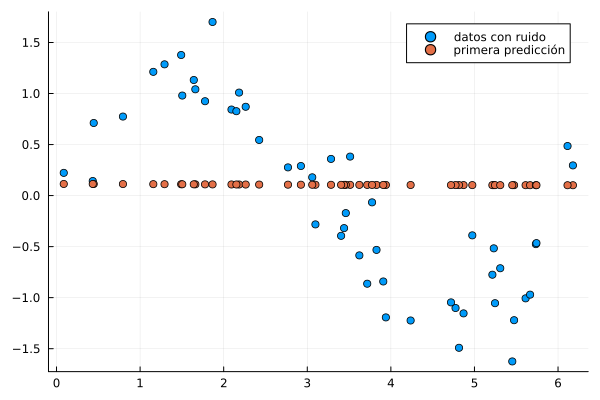

In [5]:
# Inicializar los parámetros (y también los estados de las capas, solo relevante si la red neuronal tiene estado)
parameters, layer_states = Lux.setup(rng, model)

y_initial_prediction, layer_states = model(x_samples, parameters, layer_states)
scatter!(x_samples[:], y_initial_prediction[:], label="primera predicción")

In [6]:
# Función de pérdida
function loss_fn(p, ls)
    y_prediction, new_ls = model(x_samples, p, ls)
    loss = 0.5 * mean((y_prediction .- y_samples).^2)
    return loss, new_ls
end

loss_fn (generic function with 1 method)

In [20]:
# Usar descenso de gradiente simple, pero cambiar a ADAM si lo deseas
opt = Descent(LEARNING_RATE)
opt_state = Optimisers.setup(opt, parameters)

# Bucle de entrenamiento
loss_history = []
for epoch in 1:N_EPOCHS
    (loss, layer_states,), back = pullback(loss_fn, parameters, layer_states)
    grad, _ = back((1.0, nothing))

    opt_state, parameters = Optimisers.update(opt_state, parameters, grad)

    push!(loss_history, loss)
    if epoch % 5000 == 0
        println("Epoch: $epoch, Loss: $loss")
    end
end

Epoch: 5000, Loss: 0.05782321820730177
Epoch: 10000, Loss: 0.05877243191267874
Epoch: 15000, Loss: 0.05497703459425403
Epoch: 20000, Loss: 0.05390652654505339
Epoch: 25000, Loss: 0.05330399637617354
Epoch: 30000, Loss: 0.052979442045595126
Epoch: 35000, Loss: 0.052791959123659436
Epoch: 40000, Loss: 0.052671612766478304
Epoch: 45000, Loss: 0.052586923723294744
Epoch: 50000, Loss: 0.05252487207682684


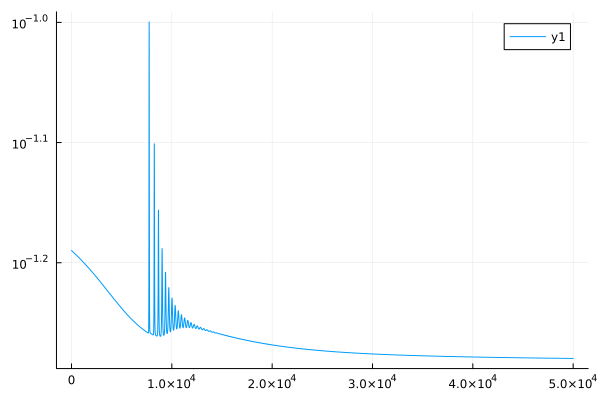

In [21]:
# Visualizar funcion de pérdida
plot(loss_history, yscale=:log10)

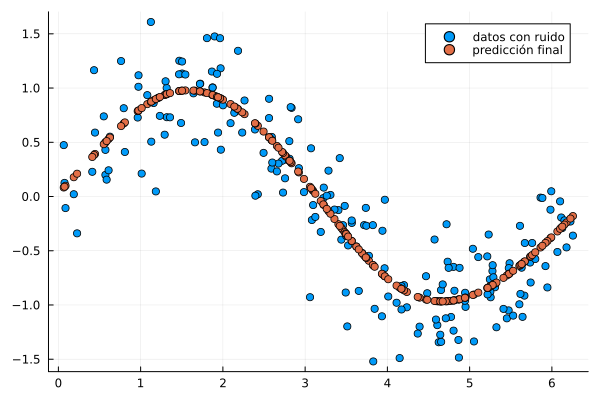

In [22]:
# Visualizar predicción final
y_final_prediction, layer_states = model(x_samples, parameters, layer_states)
scatter(x_samples[:], y_samples[:], label="datos con ruido")
scatter!(x_samples[:], y_final_prediction[:], label="predicción final")